# DL1 Assignment2 - Q1.1 draft code

This is a small help from us to save you some coding. This notebook is **not** graded, you are free to edit it.

Further advise:
1. Start with File/Save a copy in Drive
2. Set GPU usage under Runtime/Change runtime type/Hardware accelerator.

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.1 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
import timm
from torchvision import models
from matplotlib import pyplot as plt
from typing import Callable
import numpy as np

%matplotlib inline

In [ ]:
def vit_s_8():
    """ViT-S/8 is not a default torchvision model, so we provide it by timm"""
    # Accuracy approximation comes from
    # https://openreview.net/pdf?id=LtKcMgGOeLt
    # and DINO
    # https://arxiv.org/abs/2104.14294
    return timm.create_model('vit_small_patch8_224')

# Model definitions
# Optional Q: These are uncalled functions. What do you think would happen
# if we called all of them once? Why didn't we do that?
model_defs = [
    vit_s_8,
    models.vit_b_32,
    models.vgg11,
    models.vgg11_bn,
    models.resnet18,
    models.densenet121,
    models.mobilenet_v3_small,
]

# Accuracies per model
model_accs = {
    'vit_s_8': 80., # Approximated
    'vit_b_32' : 75.912,
    'vgg11' : 69.02,
    'vgg11_bn' : 70.37,
    'resnet18' : 69.758,
    'densenet121' : 74.434,
    'mobilenet_v3_small' : 67.668,
}


def measure_runtime_per_forward(model:nn.Module, no_grad:bool, batch_size:int=8):
    """Measures the time for a single pass in milliseconds"""

    # Generate fake RGB input (224x224)
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    inp = torch.rand((batch_size, 3, 224, 224))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inp = inp.to(device)
    model.to(device)
    #######################
    # END OF YOUR CODE    #
    #######################

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    # Run the model
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    if no_grad:
      with torch.no_grad():
        model(inp)
    else:
      model(inp)
    #######################
    # END OF YOUR CODE    #
    #######################

    end.record()
    torch.cuda.synchronize()
    return start.elapsed_time(end)

def drop_outliers_quantile(data, lower_quantile=0.05, upper_quantile=0.95):
    lower_bound = np.quantile(data, lower_quantile)
    upper_bound = np.quantile(data, upper_quantile)

    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    return filtered_data

def evaluate_model(model_def:Callable, no_grad:bool, batch_size:int=8):

    # Retreive initial memory allocation
    initial_vram = torch.cuda.memory_allocated()

    # Define model
    model = model_def().cuda().eval()
    # Access name as: model.__name__

    # Parameters that need to be filled
    n_params = None
    times, vrams = [], []
    mean_time = None
    mean_vram = None

    #######################
    # PUT YOUR CODE HERE  #
    #######################

    # Step 1: Calculate the number of **trainable** parameters
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # Step 2: Warm up with a few passes
    for i in range(2):
      measure_runtime_per_forward(model, no_grad, batch_size)
    # Step 3: Run N forward passes and save the runtime +
    #         the vram allocated by the model
    N=100
    for i in range(N):
      # in ms
      time = measure_runtime_per_forward(model, no_grad, batch_size)
      # in byte
      vram = torch.cuda.memory_allocated()
      times.append(time)
      vrams.append((vram-initial_vram) * 1e-6)

    # Step 4: Take the mean, preferably with dropping possible outliers
    mean_time = drop_outliers_quantile(np.array(times)).mean()
    mean_vram = drop_outliers_quantile(np.array(vrams)).mean()
    #######################
    # END OF YOUR CODE    #
    #######################

    # Clean up space for the model
    del model
    torch.cuda.empty_cache()

    return mean_time, mean_vram, n_params


In [ ]:
#######################
# PUT YOUR CODE HERE  #
#######################

# Make your plots here with matplotlib
#
# Example usage of the above functions:
n_params_models = []
acc_models = []
vram_models_no_grad = []
vram_models_grad= []
time_models_no_grad = []
time_models_grad= []
name_models = []

for model_def in model_defs:
    name = model_def.__name__
    acc = model_accs[name]
    time_no_grad, _, n_params = evaluate_model(model_def, no_grad=True)
    time_grad, _, _ = evaluate_model(model_def, no_grad=False)
    _, vram_no_grad, _ = evaluate_model(model_def, no_grad=True, batch_size = 64)
    _, vram_grad, _ = evaluate_model(model_def, no_grad=False, batch_size = 64)
    name_models.append(name)
    time_models_no_grad.append(time_no_grad)
    time_models_grad.append(time_grad)
    vram_models_no_grad.append(vram_no_grad)
    vram_models_grad.append(vram_grad)
    acc_models.append(acc)
    n_params_models.append(n_params)

print('GPU memory usage (no grad):', vram_models_no_grad)
print('GPU memory usage (with grad):', vram_models_grad)
print('Inference speed (no grad):', time_models_no_grad)
print('Inference speed (with grad):', time_models_grad)

#######################
# END OF YOUR CODE    #
#######################

GPU memory usage (no grad): [114.6454016, 358.9473075200001, 537.2420915200001, 535.399517090909, 46.861312, 36.596756479999996, 10.281471999999997]
GPU memory usage (with grad): [116.18680832, 358.94730752000004, 537.6274432000001, 534.9791334399999, 46.861312, 37.367459839999995, 10.281471999999997]
Inference speed (no grad): [100.94896341959635, 20.63502968682183, 25.841750399271646, 29.53340481652154, 7.877842145495944, 22.682003487481012, 7.1632017559475365]
Inference speed (with grad): [104.13385526869033, 23.080368762546115, 27.20942259894477, 28.07841665479872, 7.93452230029636, 22.75582750108507, 9.925953075620864]


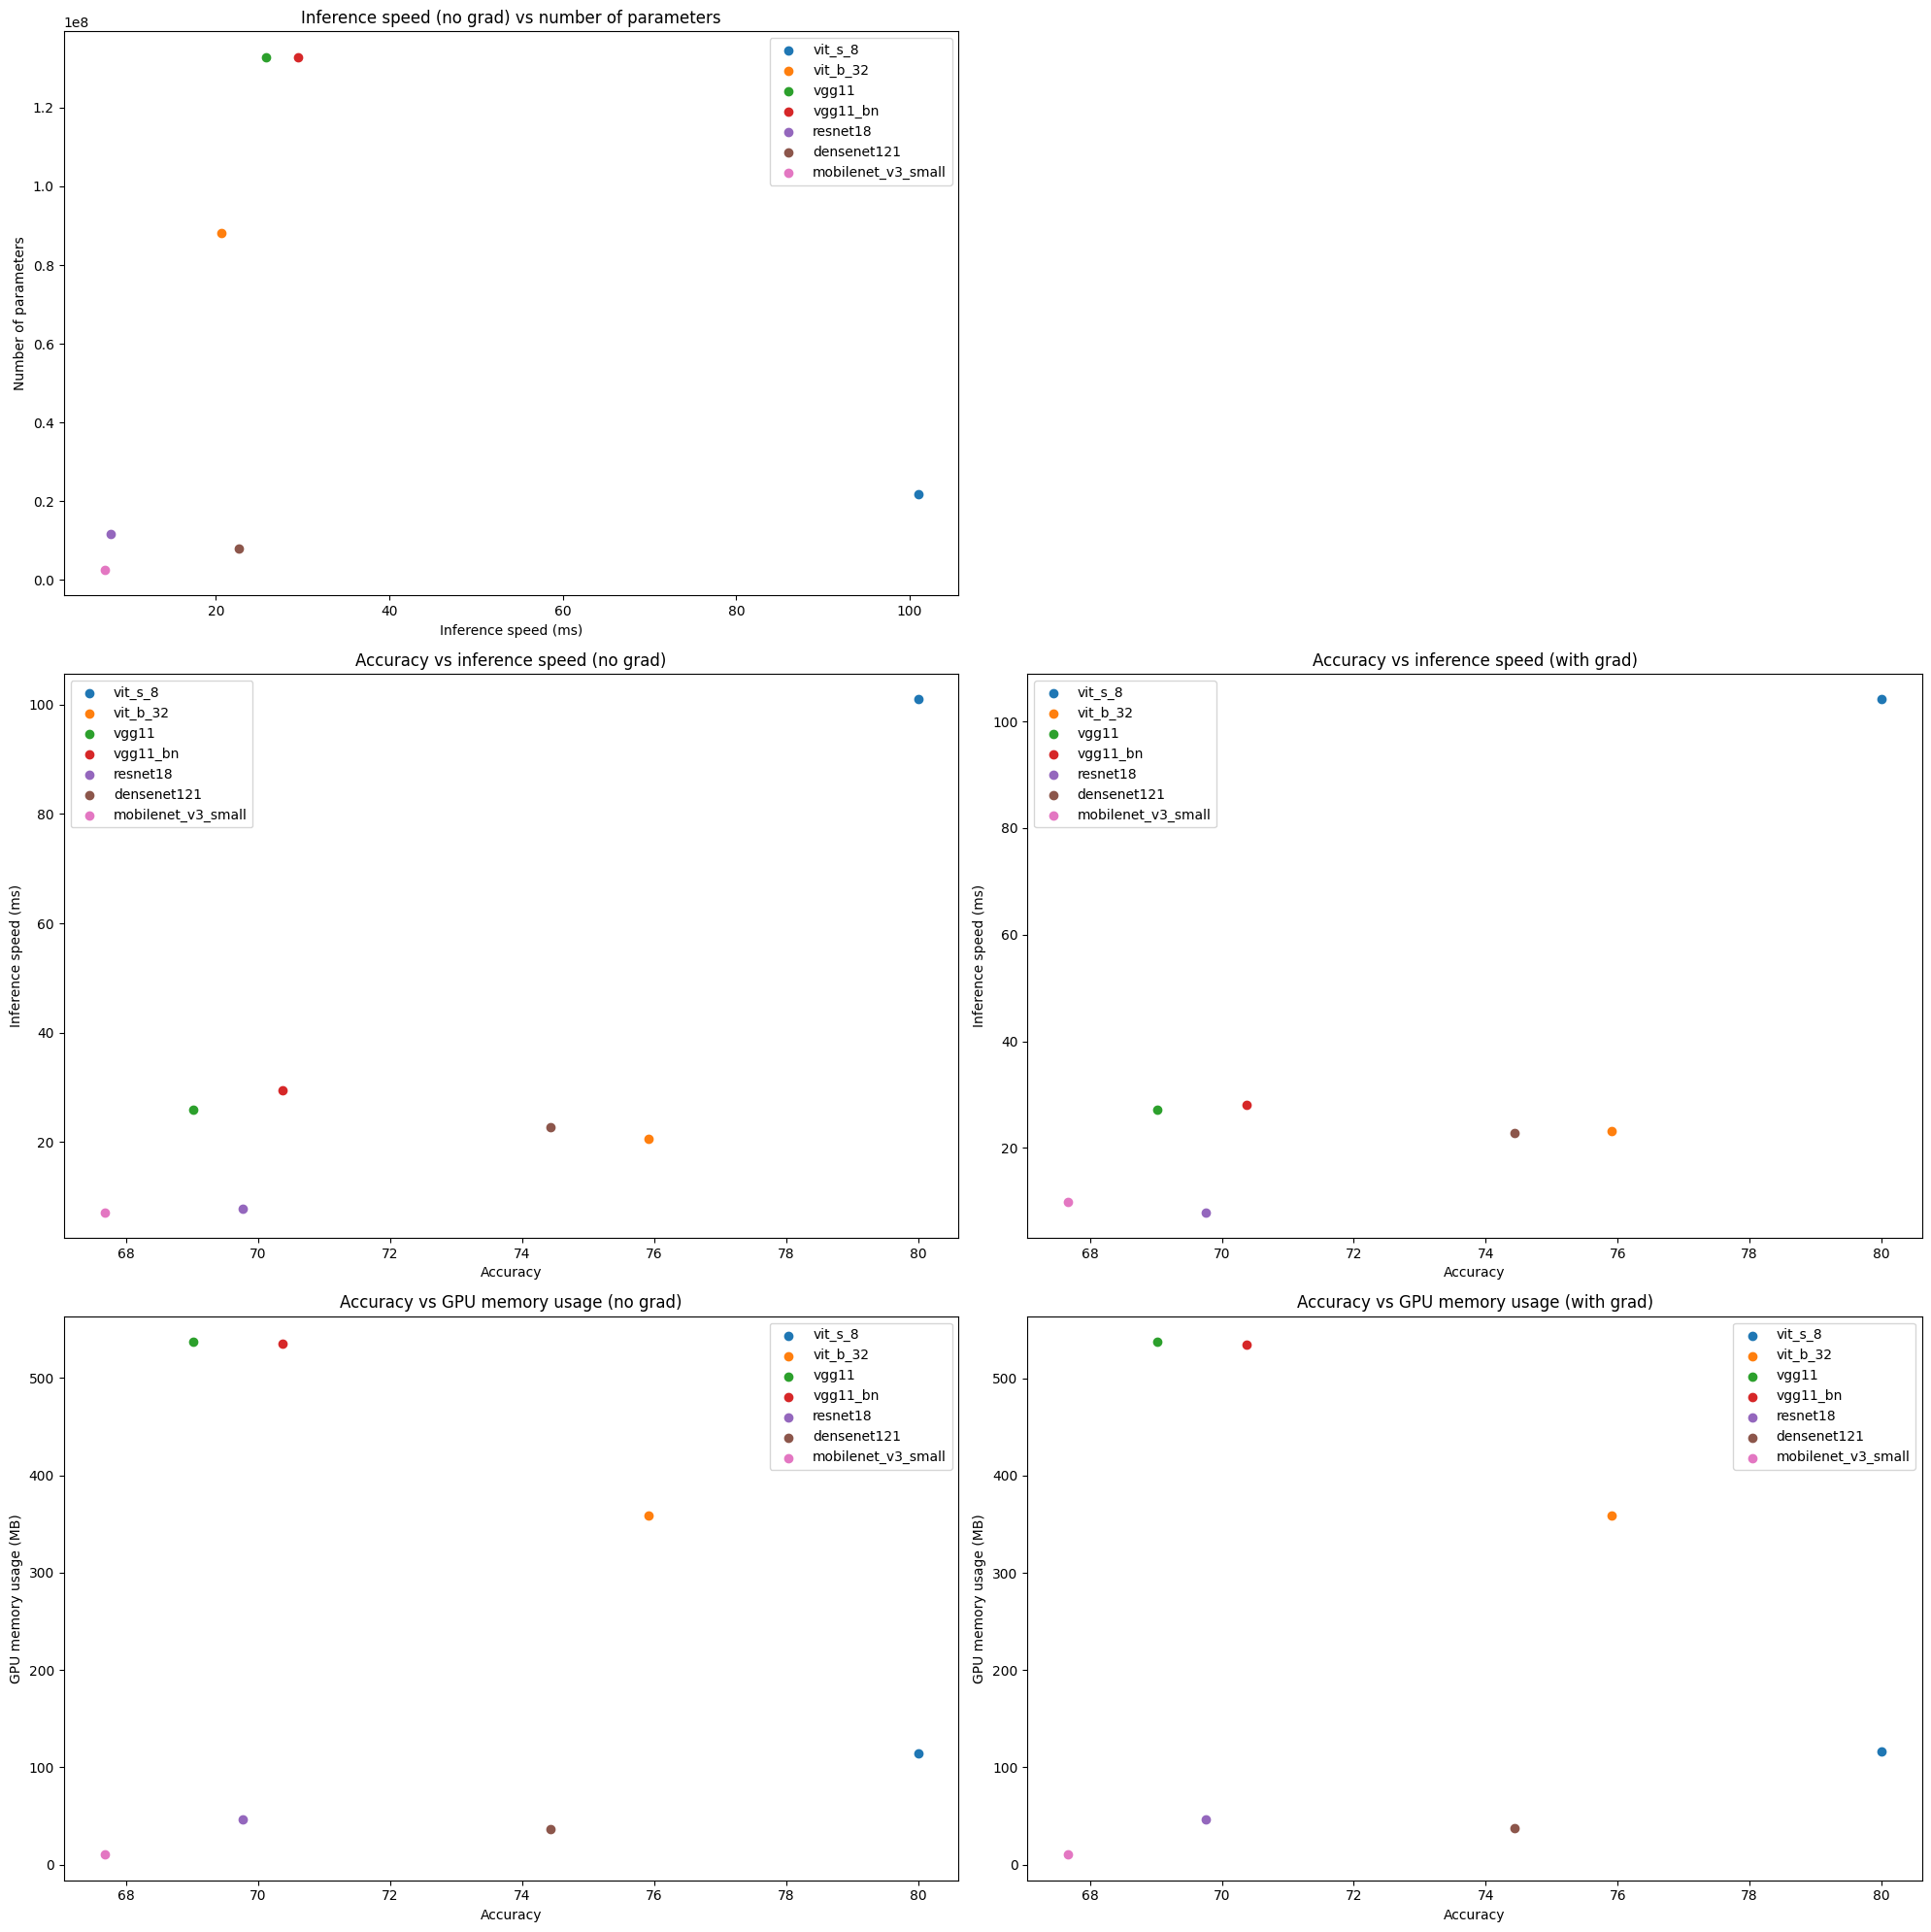

In [ ]:
#######################
# PUT YOUR CODE HERE  #
#######################
fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3, 2, figsize=(20, 20))

for i, label in enumerate(name_models):
    # inference speed (no grad) vs param
    ax1.scatter(time_models_no_grad[i], n_params_models[i], label=name_models[i])
    # accuracy vs inference speed
    ax3.scatter(acc_models[i], time_models_no_grad[i], label=name_models[i])
    ax4.scatter(acc_models[i], time_models_grad[i], label=name_models[i])
    # accuracy vs vram
    ax5.scatter(acc_models[i], vram_models_no_grad[i], label=name_models[i])
    ax6.scatter(acc_models[i], vram_models_grad[i], label=name_models[i])

ax1.set_xlabel('Inference speed (ms)')
ax1.set_ylabel('Number of parameters')
ax1.set_title('Inference speed (no grad) vs number of parameters')

ax3.set_xlabel('Accuracy')
ax3.set_ylabel('Inference speed (ms)')
ax3.set_title('Accuracy vs inference speed (no grad)')
ax4.set_xlabel('Accuracy')
ax4.set_ylabel('Inference speed (ms)')
ax4.set_title('Accuracy vs inference speed (with grad)')

ax5.set_xlabel('Accuracy')
ax5.set_ylabel('GPU memory usage (MB)')
ax5.set_title('Accuracy vs GPU memory usage (no grad)')
ax6.set_xlabel('Accuracy')
ax6.set_ylabel('GPU memory usage (MB)')
ax6.set_title('Accuracy vs GPU memory usage (with grad)')

ax1.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax2.axis('off')

plt.tight_layout()

plt.show()
#######################
# END OF YOUR CODE    #
#######################